In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.signal
from scipy.signal import savgol_filter
from  scipy import ndimage
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, normalize 
from scipy.ndimage.filters import uniform_filter1d
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from keras.optimizers import Adam, SGD
from keras import metrics, regularizers
from keras.callbacks import EarlyStopping
from keras import backend as K
import keras
import seaborn as sn
import math
import timeit
import tensorflow as tf

### Obtaining the data...

In [2]:
rutatrain = './exoTrain.csv'
rutatest = './exoTest.csv'
extrain_df = pd.read_csv(rutatrain)
extest_df = pd.read_csv(rutatest)

# Separate the label from the rest of attributes
Y_train = extrain_df.LABEL
X_train = extrain_df.drop('LABEL',axis=1)
Y_test = extest_df.LABEL
X_test = extest_df.drop('LABEL',axis=1)

# Data Preprocessing

### Preprocess functions

In [3]:
# Applying Fast Fourier Transform (FFT)
def fourier_transform(df):
    df_fft = np.abs(np.fft.fft(df, axis=1))
    return df_fft

# Handling upper outliers: personalized function
def reduce_upper_outliers(df,reduce = 0.01, half_width=4):
    length = len(df.iloc[0,:])
    remove = int(length*reduce)
    for i in df.index.values: #Para cada muestra
        values = df.loc[i,:]
        sorted_values = values.sort_values(ascending = False)
        for j in range(remove): 
            idx = sorted_values.index[j]
            new_val = 0
            count = 0
            idx_num = int(idx[5:])
            for k in range(2*half_width+1):
                idx2 = idx_num + k - half_width
                if idx2 <1 or idx2 >= length or idx_num == idx2:
                    continue
                new_val += values['FLUX.'+str(idx2)]

                count += 1
            new_val /= count # count will always be positive here
            if new_val < values[idx]: # just in case there's a few persistently high adjacent values
                df.at[i,idx] = new_val
    return df

def iterar_ruo(df, n=2):
    for i in range(n): 
        df2 = reduce_upper_outliers(df)
    return df2

# Handling outliers: Smoothing filters
def apply_filter(df,filternumber):
    #UNIFORM FILTER == 0
    if filternumber == 0:
        filt = uniform_filter1d(df, axis=1, size=50)
    #GAUSSIAN FILTER == 1
    elif filternumber == 1:
        filt = ndimage.filters.gaussian_filter(df, sigma=10)
    #Savitzky-Golay FILTER == 2
    elif filternumber == 2:
        filt = savgol_filter(df,21,4,deriv=0)

    return filt

# Normalizing data
def apply_normalization(df_train, df_test, nnumber):
    #MinMax Scaler
    if nnumber == 0:
        scaler = MinMaxScaler()
        norm_train = scaler.fit_transform(df_train)
        norm_test = scaler.transform(df_test)
    #Normalize
    elif nnumber == 1:
        norm_train = normalize(df_train)
        norm_test = normalize(df_test)
    #Robust Scaler
    elif nnumber == 2:
        scaler = RobustScaler()
        norm_train = scaler.fit_transform(df_train)
        norm_test = scaler.transform(df_test)
        
    
    norm_train = pd.DataFrame(norm_train)
    norm_test = pd.DataFrame(norm_test)
    return norm_train, norm_test

# Standardizing data
def apply_standarization(df_train, df_test):
    scaler = StandardScaler()
    norm_train = scaler.fit_transform(df_train)
    norm_test = scaler.transform(df_test)
    
    norm_train = pd.DataFrame(norm_train)
    norm_test = pd.DataFrame(norm_test)
    return norm_train, norm_test


*Function reduce_upper_outliers was extracted from this notebook: https://www.kaggle.com/muonneutrino/exoplanet-data-visualization-and-exploration

This class is created in order to speed up and enhance our preprocess flow, providing the opportunity of trying the combination of techniques desired in a fast and easy way.

### Preprocess class

In [4]:
class dataProcessor:

    def __init__(self, outlier=False, smoothing=False, fourier=False, normalize=False, standardize=False):
        self.outlier = outlier
        self.smoothing = smoothing
        self.normalize = normalize
        self.standardize = standardize
        self.fourier = fourier
    
    def process(self, df_train_x, df_test_x):
        
        # Handling outliers
        if self.outlier:
            print("Removing upper outliers...")
            df_train_x = iterar_ruo(df_train_x, P_OUTLIERS)
            df_test_x = iterar_ruo(df_test_x, P_OUTLIERS)
            
        # Apply fourier transform
        if self.fourier:
            print("Applying Fourier...")
            df_train_x = fourier_transform(df_train_x)
            df_test_x = fourier_transform(df_test_x)
        
        # Applying smoothing filters
        if self.smoothing:
            print("Applying smoothing filter...")
            df_train_x = pd.DataFrame(apply_filter(df_train_x, FILTER_NUMBER))
            df_test_x = pd.DataFrame(apply_filter(df_test_x, FILTER_NUMBER))
            
        # Normalization
        if self.normalize:
            print("Normalizing...")
            df_train_x, df_test_x = apply_normalization(df_train_x, df_test_x, TIPO_NORM)
            
        # Normalization
        if self.standardize:
            print("Standardizing...")
            df_train_x, df_test_x = apply_standarization(df_train_x, df_test_x)
        

        print("Finished Processing!")
        return df_train_x, df_test_x

In [5]:
# Change the value of P_OUTLIERS to apply reduce_upper_outliers over a specific percentage of the values of each sample
# Change the value of FILTER_NUMBER to apply a specific smoothing filter
    # FILTER_NUMBER == 0 -> UNIFORM FILTER
    # FILTER_NUMBER == 1 -> GAUSSIAN FILTER
    # FILTER_NUMBER == 2 -> SAVITZKY-GOLAY FILTER
# Change the value of TIPO_NORM to apply a specific normalization method
    # TIPO_NORM == 0 -> MaxMinScaler
    # TIPO_NORM == 1 -> normalize
    # TIPO_NORM == 2 -> RobustScaler
    
P_OUTLIERS = 2
FILTER_NUMBER = 1
TIPO_NORM = 1

Processor = dataProcessor(
    outlier = True,
    fourier = True,
    smoothing = True,
    normalize= True,
    standardize= True
)

df_train_x = X_train.copy()
df_test_x = X_test.copy()
df_train_x, df_test_x = Processor.process(df_train_x, df_test_x)

Removing upper outliers...
Applying Fourier...
Applying smoothing filter...
Normalizing...
Standardizing...
Finished Processing!


In [40]:
df_train_x

,0,1,2,3,4,5,6,7,8,9,...,3187,3188,3189,3190,3191,3192,3193,3194,3195,3196
0,0.529582,0.527766,0.524077,0.518388,0.510512,0.500208,0.487205,0.471205,0.451887,0.428991,...,0.468339,0.496892,0.521689,0.542840,0.560497,0.574847,0.586072,0.594331,0.599756,0.602445
1,0.511907,0.510097,0.506423,0.500763,0.492933,0.482703,0.469811,0.453972,0.434881,0.412292,...,0.452908,0.481046,0.505510,0.526397,0.543849,0.558044,0.569155,0.577334,0.582709,0.585373
2,0.477463,0.475667,0.472022,0.466416,0.458677,0.448588,0.435911,0.420385,0.401732,0.379739,...,0.422836,0.450171,0.473988,0.494364,0.511420,0.525314,0.536204,0.544228,0.549505,0.552122
3,0.427935,0.426156,0.422553,0.417022,0.409410,0.399521,0.387148,0.372064,0.354033,0.332885,...,0.379567,0.405760,0.428659,0.448310,0.464804,0.478271,0.488847,0.496653,0.501791,0.504341
4,0.365681,0.363922,0.360370,0.354931,0.347473,0.337831,0.325831,0.311294,0.294032,0.273931,...,0.325148,0.349926,0.371688,0.390441,0.406240,0.419179,0.429368,0.436903,0.441870,0.444337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5082,0.469748,0.471895,0.476110,0.482258,0.490111,0.499329,0.509481,0.520011,0.530228,0.539302,...,0.415585,0.409197,0.401761,0.393925,0.386243,0.379183,0.373122,0.368343,0.365047,0.363367
5083,0.484928,0.487081,0.491307,0.497464,0.505320,0.514525,0.524635,0.535082,0.545156,0.554011,...,0.425958,0.419793,0.412517,0.404789,0.397177,0.390159,0.384121,0.379354,0.376063,0.374384
5084,0.496485,0.498641,0.502870,0.509030,0.516879,0.526063,0.536130,0.546500,0.556450,0.565120,...,0.433810,0.427833,0.420694,0.413063,0.405517,0.398541,0.392529,0.387777,0.384493,0.382817
5085,0.504311,0.506467,0.510698,0.516856,0.524697,0.533864,0.543896,0.554208,0.564067,0.572606,...,0.439119,0.433276,0.426237,0.418678,0.411181,0.404239,0.398248,0.393508,0.390231,0.388559


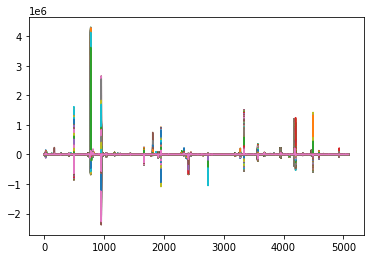

In [6]:
plt.plot(X_train)
plt.show()

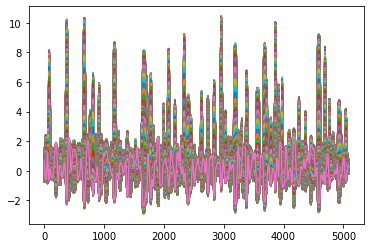

In [7]:
plt.plot(df_train_x)
plt.show()

### Handling imbalanced data: upsampling/oversampling with RandomOverSampler

Distribution before resampling Counter({1: 5050, 2: 37})
Distribution labels after resampling Counter({2: 5050, 1: 5050})


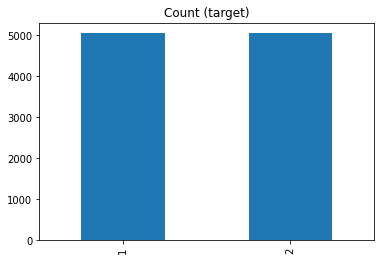

In [8]:
from sklearn.utils import resample
from imblearn.over_sampling import RandomOverSampler
from collections import Counter


# UPSAMPLING: RandomOverSampler
X_total = df_train_x.copy()
os =  RandomOverSampler(sampling_strategy='minority')
upsampling, upsampling_Y = os.fit_resample(X_total, Y_train)

print ("Distribution before resampling {}".format(Counter(Y_train)))
print ("Distribution labels after resampling {}".format(Counter(upsampling_Y)))

upsampling_Y.value_counts().plot(kind='bar', title='Count (target)');

### Functions

In [9]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def specificity_m(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    specificity = true_negatives / (possible_negatives + K.epsilon())
    return specificity

def imb_accuracy(y_true, y_pred):
    recall = recall_m(y_true, y_pred)
    specificity = specificity_m(y_true, y_pred)
    score = (0.5 * recall) + (0.5 * specificity)
    return score

# Transformation of train labels to OneHotEncoder format
def transform_Y(y_samp, y_sampTest):
    y_samp[y_samp < 2] = 0
    y_samp[y_samp > 1] = 1
    y_sampTest[y_sampTest < 2] = 0
    y_sampTest[y_sampTest > 1] = 1
    Y_train_ohe = np.zeros((y_samp.shape[0], 2))

    for i in range(y_samp.shape[0]):
        Y_train_ohe[i, int(y_samp[i])] = 1
        
    return Y_train_ohe, y_sampTest

### Creation of the model

In [10]:
# Crear y configurar CNN
def create_model(X_samp, activation='relu', learn_rate=0.01):
    model = Sequential()
    model.add(Conv1D(filters = 16, input_shape = (X_samp.shape[1],1), kernel_size=(3), activation = activation, kernel_regularizer='l2', padding='same'))
    model.add(MaxPooling1D(pool_size = 2, strides = 2))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(32, activation = activation, kernel_regularizer='l2'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = "sigmoid", kernel_regularizer='l2'))
    
    optimizer = Adam(lr=learn_rate)
    #Adam is a optimized version of a SGD (Stochastic Gradient Descendant) optimizer.
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[imb_accuracy])
    #binary_crossentropy is the go-to loss function for classification tasks, either balanced or imbalanced. 
    #It is the first choice when no preference is built from domain knowledge yet.
    return model
    

### Training and prediction

In [11]:
EPOCHS = 50
VAL_SPLIT = 0.2
BATCH_SIZE = 75
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

Epoch 1/50
108/108 [==============================] - 11s 27ms/step - loss: 1.7999 - imb_accuracy: 0.9140 - val_loss: 0.1914 - val_imb_accuracy: 1.0000
Epoch 2/50
108/108 [==============================] - 1s 12ms/step - loss: 0.2206 - imb_accuracy: 0.9875 - val_loss: 0.2235 - val_imb_accuracy: 1.0000
Epoch 3/50
108/108 [==============================] - 1s 12ms/step - loss: 0.2526 - imb_accuracy: 0.9847 - val_loss: 0.1402 - val_imb_accuracy: 1.0000
Epoch 4/50
108/108 [==============================] - 1s 12ms/step - loss: 0.2146 - imb_accuracy: 0.9873 - val_loss: 0.1902 - val_imb_accuracy: 1.0000
Epoch 5/50
108/108 [==============================] - 1s 12ms/step - loss: 0.2377 - imb_accuracy: 0.9876 - val_loss: 0.1843 - val_imb_accuracy: 1.0000
Epoch 6/50
108/108 [==============================] - 1s 12ms/step - loss: 0.2065 - imb_accuracy: 0.9829 - val_loss: 0.1609 - val_imb_accuracy: 1.0000
Epoch 7/50
108/108 [==============================] - 1s 11ms/step - loss: 0.2230 - imb_accur

c:\users\swade\miniconda3\envs\project\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
c:\users\swade\miniconda3\envs\project\lib\site-packages\tensorflow\python\keras\engine\sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       565
           1       0.80      0.80      0.80         5

    accuracy                           1.00       570
   macro avg       0.90      0.90      0.90       570
weighted avg       1.00      1.00      1.00       570

Confussion matrix


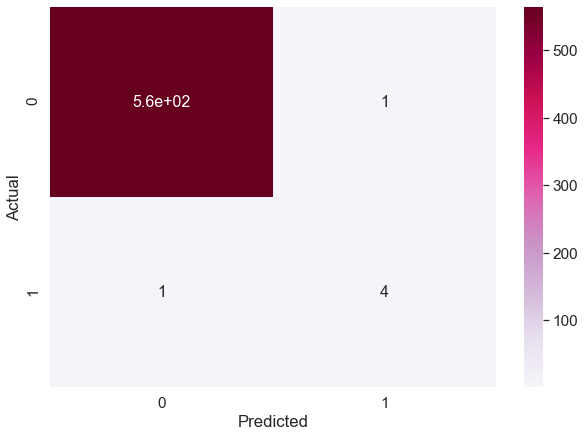

In [12]:
Test_Y = Y_test.copy()
X_sampTest = df_test_x.copy()
X_sampTest = np.expand_dims(X_sampTest, axis=2)
upsamplingg_Y = upsampling_Y.copy()
X_sampUp = upsampling.copy()
X_sampUp = np.expand_dims(X_sampUp, axis=2)

# Creation and training of the NN
modelUp = create_model(X_sampUp)
Y_train_ohe, Test_Y = transform_Y(upsamplingg_Y, Test_Y)
start_time_train = timeit.default_timer()
baseline_historyUp = modelUp.fit(X_sampUp, Y_train_ohe, validation_split = VAL_SPLIT, 
                            epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True, callbacks=[early_stop])
upsampling_elapsed = timeit.default_timer() - start_time_train
print('Training time: ' + str(upsampling_elapsed))


# Representation of the NN arquitecture
print(modelUp.summary())

# Prediction
y_test_pred = modelUp.predict_classes(np.array(X_sampTest))
y_scores = modelUp.predict_proba(X_sampTest)[:,1]

# Confussion matrix and classification_report
print(classification_report(Test_Y, y_test_pred))

print('Confussion matrix') 
matrix = confusion_matrix(Test_Y, y_test_pred)
df_cm = pd.DataFrame(matrix, columns=np.unique(Test_Y), index = np.unique(Test_Y))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4) 
sn.heatmap(df_cm, cmap="PuRd", annot=True,annot_kws={"size": 16})
TN = matrix[0][0]
FP = matrix[0][1]
FN = matrix[1][0]
TP = matrix[1][1]

# Prediction metrics
upsampling_accuracy = accuracy_score(Test_Y, y_test_pred)
upsampling_imbaccuracy = balanced_accuracy_score(Test_Y, y_test_pred)
upsampling_precision = precision_score(Test_Y, y_test_pred)
upsampling_recall = recall_score(Test_Y, y_test_pred)
upsampling_f1 = f1_score(Test_Y, y_test_pred)
upsampling_auc = roc_auc_score(Test_Y, y_scores)
upsampling_especifidad = TN / (TN + FP)


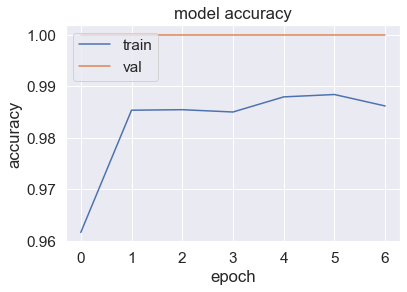

In [38]:
plt.plot(baseline_historyUp.history['imb_accuracy'])
plt.plot(baseline_historyUp.history['val_imb_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

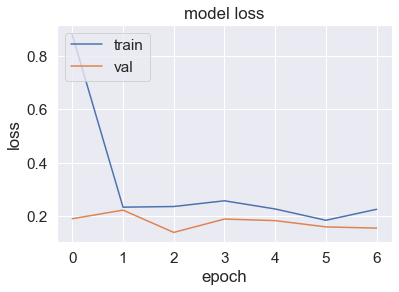

In [39]:
plt.plot(baseline_historyUp.history['loss'])
plt.plot(baseline_historyUp.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Results

In [13]:
print('\t\t Upsampling\n')
print("Accuracy:\t", "{:0.10f}".format(upsampling_accuracy))
print("Precision:\t", "{:0.10f}".format(upsampling_precision))
print("Recall:\t\t", "{:0.10f}".format(upsampling_recall))
print("Specificity:\t", "{:0.10f}".format(upsampling_especifidad))
print("\nF1 Score:\t", "{:0.10f}".format(upsampling_f1))
print("ROC AUC:\t", "{:0.10f}".format(upsampling_auc))
print("Balanced\nAccuracy:\t", "{:0.10f}".format(upsampling_imbaccuracy))
print("Training time:\t", "{:0.2f}s".format(upsampling_elapsed))

		 Upsampling

Accuracy:	 0.9964912281
Precision:	 0.8000000000
Recall:		 0.8000000000
Specificity:	 0.9982300885

F1 Score:	 0.8000000000
ROC AUC:	 0.9996460177
Balanced
Accuracy:	 0.8991150442
Training time:	 18.98s


In [31]:
y_test_pred

array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [65]:
np.array(df_train_x.iloc[2])

array([0.4774634 , 0.47566664, 0.47202244, ..., 0.5442282 , 0.54950486,
       0.55212173])

In [68]:
print(np.array(X_train.iloc[2]))

[532.64 535.92 513.73 ... -28.91 -70.02 -96.67]


In [67]:
np.set_printoptions(threshold=1000)